[![Node Classification using GCN](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roman-4erkasov/gnn-base/blob/main/GraphConvolutionNetwork.ipynb)

# Решение задачи из  СORA Dataset с помощью  Graph Convolution Network

Оригинал взят из курса: https://lucmos.github.io/DLAI-s2-2020-tutorials/

Ссылка на колаб: [DLAI-s2-2020](https://erodola.github.io/DLAI-s2-2020/)


## Подготовка данных

In [ ]:
# @title Импорты
import sys
import math
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# @title Скачиваем датасет и вспомогательные функции
%%capture

!git clone https://github.com/tkipf/pygcn.git

sys.path.insert(0,'./pygcn/pygcn')
from utils import load_data

def get_predictions(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    return correct

def accuracy(output, labels):
    correct = get_predictions(output, labels)
    correct = correct.sum()
    return correct / len(labels)


In [ ]:
# @title Загружаем данные
adj, features, labels, idx_train, idx_val, idx_test = load_data(path='pygcn/data/cora/')

Loading cora dataset...


/content/./pygcn/pygcn/utils.py:80: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


## Решаем задачу с помощью MLP

In [ ]:
# @title Создаем MLP

def mlp_accuracy(model):
    model.eval()
    y_pred = model(features[idx_test])
    acc = accuracy(y_pred, labels[idx_test])
    print(f"Accuracy: {acc:.5}")
    return acc


mlp = th.nn.Sequential(
    th.nn.Linear(1433, 500),
    th.nn.ReLU(),
    th.nn.Linear(500, 100),
    th.nn.ReLU(),
    th.nn.Linear(100, 7)
)

_ = mlp_accuracy(mlp)

Accuracy: 0.057


In [ ]:
# @title Обучаем MLP

opt = th.optim.Adam(mlp.parameters())

losses_mlp = []
mlp.train()
for epoch in range(1_000):
    opt.zero_grad()
    output = mlp(features[idx_train])
    loss = th.nn.functional.cross_entropy(output, labels[idx_train])  # train only on the train samples
    loss.backward()
    opt.step()
    losses_mlp.append(loss.item())
    if epoch%200==0:
      print(f"{epoch=} loss={loss.item()}")


epoch=0 loss=1.9353984594345093
epoch=200 loss=0.0034277255181223154
epoch=400 loss=0.0005349637940526009
epoch=600 loss=0.00021893135271966457
epoch=800 loss=0.00011959824769292027


In [ ]:
accmlp = mlp_accuracy(mlp)

Accuracy: 0.493


Text(0.5, 1.0, 'MLP learning curve')

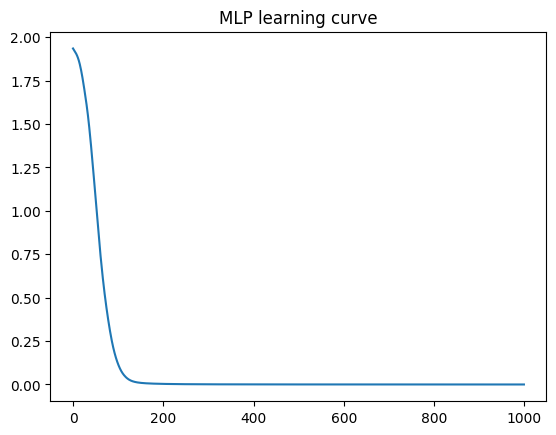

In [ ]:
plt.plot(losses_mlp)
plt.title("MLP learning curve")

## Graph Convolution Network

In [ ]:
# @title Создаем GCN

class GCNConv(th.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = th.nn.Parameter(th.FloatTensor(in_features, out_features))
        self.bias = th.nn.Parameter(th.FloatTensor(out_features))
        self.reset_parameters()

    def forward(self, input, adj):
        support = th.spmm(adj,input)
        out = th.spmm(support, self.weight)+self.bias
        return out

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)



class GCN(th.nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        super().__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, nclass)

    def forward(self, x, adj):
        x = th.nn.functional.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return x


def gcn_accuracy(model):
    model.eval()
    y_pred = model(features, adj)  # Do you notice the difference?
    acc = accuracy(y_pred[idx_test], labels[idx_test])
    print(f"Accuracy: {acc:.5}")
    return acc


gcn = GCN(1433, 50, 7)

print("Loss before training")
_ = gcn_accuracy(gcn)

Loss before training
Accuracy: 0.057


In [ ]:
# @title Обучаем GCN
opt = th.optim.Adam(gcn.parameters())

losses_gcn = []
gcn.train()

for epoch in range(2000):
    opt.zero_grad()
    output = gcn(features, adj)  # compute all outputs, even for the nodes in the test set
    loss = th.nn.functional.cross_entropy(
        output[idx_train], labels[idx_train]
    )  # Train only on the train samples!
    loss.backward()
    opt.step()
    losses_gcn.append(loss.item())
    if epoch % 200 == 0:
      print(f"{epoch=} loss={loss.item()}")

epoch=0 loss=2.003244400024414
epoch=200 loss=1.053797721862793
epoch=400 loss=0.3771067261695862
epoch=600 loss=0.1557064950466156
epoch=800 loss=0.07784589380025864
epoch=1000 loss=0.04461335763335228
epoch=1200 loss=0.02808401547372341
epoch=1400 loss=0.01893133856356144
epoch=1600 loss=0.013437125831842422
epoch=1800 loss=0.009917529299855232


In [ ]:
accgcn = gcn_accuracy(gcn)

Accuracy: 0.797


Text(0.5, 1.0, 'GCN learning curve')

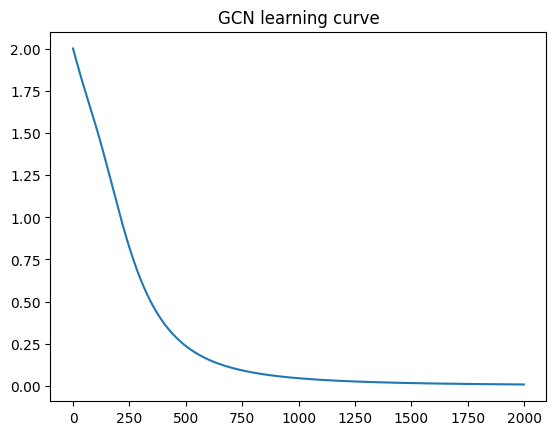

In [ ]:
plt.plot(losses_gcn)
plt.title("GCN learning curve")

## Pytorch Geometric

In [ ]:
# @title Устанавливаем и импортируем PyG
%%capture

%pip install torch_geometric
import torch_geometric as pyg

In [ ]:
# @title Конвертируем матрицу смежности в список ребер

edge_list = []
adj_dense = adj.to_dense()
for i in range(adj_dense.shape[0]):
    for j in range(adj_dense.shape[1]):
         if adj_dense[i][j] >0:
             edge_list.append((i,j))
edge_index = th.LongTensor(edge_list).T

In [ ]:
# @title Создаем GCN
class GCN(th.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = pyg.nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg.nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = th.nn.functional.dropout(x, p=0.3, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = th.nn.functional.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

def gcn_accuracy(model):
    """
    Perfom a forward pass `y_pred = model(x)` and computes the accuracy
    between `y_pred` and `y_true`.

    It is particuarly tricky to perform batching in GCN.
    As you can see, here the forward pass is performed on the whole graph
    """
    model.eval()
    y_pred = model(features, edge_index)  # Do you notice the difference?
    acc = accuracy(y_pred[idx_test], labels[idx_test])
    print(f"Accuracy: {acc:.5}")
    return acc

In [ ]:
# @title Обучаем GCN

model = GCN(
    in_channels=1433,
    hidden_channels=50,
    out_channels=7,
)
optimizer = th.optim.Adam(model.parameters(), lr=0.001)
losses_pyg = []
gcn.train()
for epoch in range(2000):
    opt.zero_grad()
    output = model(features, edge_index)
    loss = th.nn.functional.cross_entropy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    losses_pyg.append(loss.item())
    if epoch % 200 == 0:
      print(f"{epoch=} loss={loss.item()}")


epoch=0 loss=1.947059154510498
epoch=200 loss=0.6759541034698486
epoch=400 loss=0.13573549687862396
epoch=600 loss=0.03772939369082451
epoch=800 loss=0.010181263089179993
epoch=1000 loss=0.004594914615154266
epoch=1200 loss=0.000722023076377809
epoch=1400 loss=0.0025770054198801517
epoch=1600 loss=0.0011901372345164418
epoch=1800 loss=0.0003338935784995556


In [ ]:
_=gcn_accuracy(model)

Accuracy: 0.74


tensor(0.7400, dtype=torch.float64)

Text(0.5, 1.0, 'GCN learning curve')

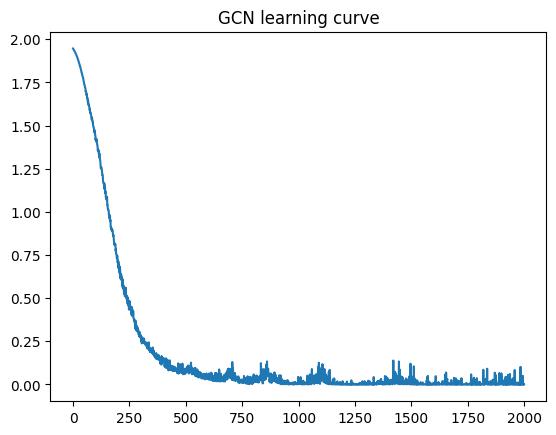

In [ ]:
plt.plot(losses_pyg)
plt.title("GCN learning curve")